#Dataset1-Big(85282 rows)

##Import Dataset

In [1]:
import pandas as pd;

#Loading dataset and rename columns

df=pd.read_excel("healthtapQAs_v1.xlsx");
df.columns=["questions","answers"];

df

,questions,answers
0,zirconium dental implants. how common is it us...,a majority of the dental implants placed are t...
1,zoloft/ sertaline cause heart racing can't sit...,check with your doc could be side effect of th...
2,zoloft (sertraline) side effects? does it make...,it can be related to either weight gain or los...
3,yellow skin around wound from cat bite. why?,this may be the secondary result of a resolvin...
4,yeast infection and open sores major swelling ...,bathing in a bath with baking soda may help de...
...,...,...
85277,what is the best: a conventional angiography o...,for small vessels conventional angiography is ...
85278,what is unique about taking medicine every 24 ...,try taking one half tab every day. but 10mg si...
85279,what treat should be of following sypmtoms pai...,your description of the pain sounds neuropathi...
85280,can you explain incomplete right bundle branch...,the righty and left ventricles are induced to ...


##Data Preprocessing

In [2]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#keeping only words in the sentence and removing punctuations.

def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
#print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
#print(cleaned_sentences_with_stopwords[0]);

In [3]:
print(cleaned_sentences_with_stopwords[0]);

zirconium dental implants how common is it used now is there any advantages or benefits over titanium implants cons  pros please thanks


##Glove Model

In [4]:
from gensim.models import Word2Vec 
import gensim.downloader as api

#loading Glove data
glove_model=None;
try:
    glove_model = gensim.models.KeyedVectors.load("./glovemodel.mod")
    print("Loaded saved glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Downloaded and saved glove model")
    


glove_embedding_size=len(glove_model['computer']);

[==================================================] 100.0% 104.8/104.8MB downloaded
Downloaded and saved glove model


In [5]:
#creating vectors
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));

        return vec.reshape(1, -1)

In [6]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
#finding cosine similarity from vectors

def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1
    index_sim=-1
    for index,faq_embedding in enumerate(sentence_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0]
        print(index, sim, sentences[index])
        if sim>max_sim:
            max_sim=sim
            index_sim=index
    print("\n")
    print("Question: ",question)
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print(FAQdf.iloc[index_sim,1]) 

In [7]:
question_orig="WHow to keep good health?"
#question_orig=input()
question=clean_sentence(question_orig,stopwords=False)

In [8]:
#With Glove
import numpy
sent_embeddings=[]
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,glove_model))
    
question_embedding=getPhraseEmbedding(question,glove_model)

retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences)

Streaming output truncated to the last 5000 lines.
80289 0.8361846842350927 midsternal chest pain lead
80290 0.8702302467622663 emergency room high blood pressure
80291 0.9337534846217818 mean systolic diastolic blood pressure readings close number 11090
80292 0.7063502932107116 difference benicar olmesartan hct losartan hctz
80293 0.86948833033664 head dizzy spell short breath mean
80294 0.8257503767424828 heartbeat machine called
80295 0.8616124195415312 mean left womans chest sore
80296 0.9124896144199084 whats average blood pressure for12 year olds
80297 0.6856792733843835 vitamin help reduce ldl
80298 0.7221160193340072 causes constant passing feaces meal remedied
80299 0.9456437661649293 makes peritonitis pleurisy pericarditis cause great deal pain
80300 0.8044034064716866 borderline inferior q wave mean
80301 0.6153741660869423 concerns acetaminophen ibuprofen liver effects safer aspirin inflammation headache pericarditis
80302 0.3870945191870507 definition description mitral va

#Implementing Chatbot using Glove

In [9]:
#embedding the exsiting dataset
sent_embeddings=[];
for sent in cleaned_sentences:
  sent_embeddings.append(getPhraseEmbedding(sent,glove_model));

In [10]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
import numpy
import time

print("Welcome to the Question Answering System")      

while True:
  print("Question:") 
  
  question_orig=input()
  
  if (question_orig.lower()=='quit'):
    break
  measure1 = time.time()
  question=clean_sentence(question_orig,stopwords=False);
  


  question_embedding=getPhraseEmbedding(question,glove_model);  
  def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
      sim=cosine_similarity(faq_embedding,question_embedding)[0][0]
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;
    #print("\n")
    #print("Question: ",question)
    #print("\n");
    #print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    #print(FAQdf.iloc[index_sim,1]) 
    print("Answer:",FAQdf.iloc[index_sim,1])
    print("----------------------")
    measure2 = time.time()
    print("Response Time",measure2 - measure1)
    print("----------------------")
    print("\n");
    print("Enter Quit to exit: ")
  retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);




print("----------------------")
print("Thank You")
print("----------------------")

Welcome to the Question Answering System
Question:
How to take care of health?
Answer: hi toocute1 those are normal numbers!
----------------------
Response Time 15.49782395362854
----------------------


Enter Quit to exit: 
Question:
Which food is healthy?
Answer: although some feel queasy eating red meat when they have abstained for a long while there are no ill health effects. interestingly the gut bacteria of meat eaters release tmao after digesting steak which has been linked to heart attacks and strokes. vegans who tried red meat as part of this nejm study lacked these gut bacteria and did not have any increase in tmao after a one day red meat binge.
----------------------
Response Time 15.411398887634277
----------------------


Enter Quit to exit: 
Question:
Quit
----------------------
Thank You
----------------------


#Dataset2-Easy

##Import Dataset

In [11]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv")
df.columns=["questions","answers","AnswerCode"]

df

,questions,answers,AnswerCode
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [12]:
import pandas as pd

#Load dataset and rename columns 

df_test=pd.read_excel("FAQ_test_Easy.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,"How are the DS jobs on the market, please?",2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How is DS hiring impacted due to Covid?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,In a data scientist what qualifications and at...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Are employers looking for an advanced ML degree?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,On a typical day what does a data scientist do?,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,Do we need to study algorithms for a data scie...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,What is the mathematical background needed to ...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview are in a data sc...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How proficient a data scientist has to be in c...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##Data Preprocessing

In [13]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#cleaning test data questions
def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(tf,stopwords=False):    
    sents=tf[["questions"]]
    cleaned_sentences=[]

    for index,row in tf.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords)
        cleaned_sentences.append(cleaned)
    return cleaned_sentences

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences)

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords)

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

In [14]:
print(cleaned_sentences_with_stopwords[0])

what does the job hunting experience look like 


##Glove Model

In [15]:
from gensim.models import Word2Vec 
import gensim.downloader as api

glove_model=None
try:
    glove_model = gensim.models.KeyedVectors.load("glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")

glove_embedding_size=len(glove_model['computer'])

Loaded glove model


In [16]:
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test)

['how is the job searching experience nowadays', 'how are the ds jobs on the market please', 'how is ds hiring impacted due to covid', 'in a data scientist what qualifications and attributes do employers look for', 'are employers looking for an advanced ml degree', 'on a typical day what does a data scientist do', 'do we need to study algorithms for a data science interview', 'what is the mathematical background needed to be a data scientist ', 'how many rounds of interview are in a data science interview ', 'how proficient a data scientist has to be in coding']


In [17]:
def getWordVec(word,model):
        samp=model['computer']
        vec=[0]*len(samp);
        try:
                vec=model[word]
        except:
                vec=[0]*len(samp)
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel)
        vec=numpy.array([0]*len(samp))
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1
            vec=vec+numpy.array(getWordVec(word,embeddingmodel))

        return vec.reshape(1, -1)

In [18]:
#With glove for original question dataset
import numpy
sent_embeddings=[]
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,glove_model))

In [19]:
#With glove for test question dataset
import numpy
sent_embeddings_test=[]
for sent_test in cleaned_sentences_test:
    sent_embeddings_test.append(getPhraseEmbedding(sent_test,glove_model))

In [20]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1
    index_sim=-1
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0]
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim
        index_sim=index

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])        
  df_test=FAQdf_test 
retrieveAndPrintFAQAnswer(sent_embeddings_test,sent_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test)



Question:  how is the job searching experience nowadays


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  how are the ds jobs on the market please


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  how is ds hiring impacted due to covid


Retrieved:  How do

In [21]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,1.0,NaN,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,"How are the DS jobs on the market, please?",2,1.0,NaN,Any insights you can offer about the DS job ma...,What does the job hunting experience look like ?
2,How is DS hiring impacted due to Covid?,3,6.0,NaN,What's the impact of Covid on hiring for DS ro...,How does a typical day of a data scientist loo...
3,In a data scientist what qualifications and at...,4,6.0,NaN,What skills and qualities do employers look fo...,How does a typical day of a data scientist loo...
4,Are employers looking for an advanced ML degree?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,On a typical day what does a data scientist do?,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,Do we need to study algorithms for a data scie...,7,6.0,NaN,Is preparation of algorithms and data structur...,How does a typical day of a data scientist loo...
7,What is the mathematical background needed to ...,8,6.0,NaN,What is the mathematical background required t...,How does a typical day of a data scientist loo...
8,How many rounds of interview are in a data sc...,9,6.0,NaN,What are the various rounds in a data scientis...,How does a typical day of a data scientist loo...
9,How proficient a data scientist has to be in c...,10,6.0,NaN,What level of proficiency is needed for a data...,How does a typical day of a data scientist loo...


In [22]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,1.0,correct,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,"How are the DS jobs on the market, please?",2,1.0,InCorrect,Any insights you can offer about the DS job ma...,What does the job hunting experience look like ?
2,How is DS hiring impacted due to Covid?,3,6.0,InCorrect,What's the impact of Covid on hiring for DS ro...,How does a typical day of a data scientist loo...
3,In a data scientist what qualifications and at...,4,6.0,InCorrect,What skills and qualities do employers look fo...,How does a typical day of a data scientist loo...
4,Are employers looking for an advanced ML degree?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,On a typical day what does a data scientist do?,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,Do we need to study algorithms for a data scie...,7,6.0,InCorrect,Is preparation of algorithms and data structur...,How does a typical day of a data scientist loo...
7,What is the mathematical background needed to ...,8,6.0,InCorrect,What is the mathematical background required t...,How does a typical day of a data scientist loo...
8,How many rounds of interview are in a data sc...,9,6.0,InCorrect,What are the various rounds in a data scientis...,How does a typical day of a data scientist loo...
9,How proficient a data scientist has to be in c...,10,6.0,InCorrect,What level of proficiency is needed for a data...,How does a typical day of a data scientist loo...


In [23]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [24]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[8, 1],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]],

       [[3, 6],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]]])

In [25]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

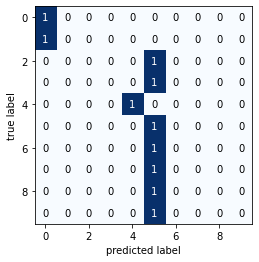

In [26]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [27]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.14      1.00      0.25         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.30        10
   macro avg       0.16      0.30      0.19        10
weighted avg       0.16      0.30      0.19        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Dataset3-Medium

##Import Dataset

In [28]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv")
df.columns=["questions","answers","AnswerCode"]

df

,questions,answers,AnswerCode
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [29]:
import pandas as pd

#Load dataset and examine dataset, rename columns to questions and answers

df_test=pd.read_excel("FAQ_test_Medium.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,Please provide how DS jobs are in the market?,2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How has the Covid impacted DS hiring?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,What skills do employers want from data scienc...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Is advanced degree in ML required?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,What data scientist do in a typical day?,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,For an interview in data science are we requir...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,What is the mathematical background required t...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview are required to c...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How much proficient a data scientist should be...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##Data Preprocessing

In [30]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#cleaning test data questions
def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(tf,stopwords=False):    
    sents=tf[["questions"]]
    cleaned_sentences=[]

    for index,row in tf.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords)
        cleaned_sentences.append(cleaned)
    return cleaned_sentences

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences)

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords)

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

In [31]:
print(cleaned_sentences_with_stopwords[0])

what does the job hunting experience look like 


##Glove Model

In [32]:
from gensim.models import Word2Vec 
import gensim.downloader as api

glove_model=None
try:
    glove_model = gensim.models.KeyedVectors.load("glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")

glove_embedding_size=len(glove_model['computer'])

Loaded glove model


In [33]:
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test)

['how does job searching experience would look', 'please provide how ds jobs are in the market', 'how has the covid impacted ds hiring', 'what skills do employers want from data science positions', 'is advanced degree in ml required', 'what data scientist do in a typical day', 'for an interview in data science are we required to study algorithms', 'what is the mathematical background required to be a data scientist ', 'how many rounds of interview are required to clear data scientist interview ', 'how much proficient a data scientist should be in coding']


In [34]:
def getWordVec(word,model):
        samp=model['computer']
        vec=[0]*len(samp);
        try:
                vec=model[word]
        except:
                vec=[0]*len(samp)
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel)
        vec=numpy.array([0]*len(samp))
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1
            vec=vec+numpy.array(getWordVec(word,embeddingmodel))

        return vec.reshape(1, -1)

In [35]:
#With glove for original question dataset
import numpy
sent_embeddings=[]
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,glove_model))

In [36]:
#With glove for test question dataset
import numpy
sent_embeddings_test=[]
for sent_test in cleaned_sentences_test:
    sent_embeddings_test.append(getPhraseEmbedding(sent_test,glove_model))

In [37]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1
    index_sim=-1
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0]
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim
        index_sim=index

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])        
  df_test=FAQdf_test 
retrieveAndPrintFAQAnswer(sent_embeddings_test,sent_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test)



Question:  how does job searching experience would look


Retrieved:  How does a typical day of a data scientist look like?
Answer: Here are some tasks in the typical day of a data scientist:

Make a plan for the day
Look at data, what clean up is required, figure out what models can be built
Talk to various stakeholders about what modeling is possible and help them narrow down to something useful for the business
Build models, test and debug (takes a long time)
Parameter tuning – test tons and tons of parameters (takes a long time)
Come up with prod architecture to get deployment ready
Write ML pipeline for production ready modeles – deploy them
Wait for long time till we have a significant sample to see if they are working
Analyze and see whether the models are working as expected, have any impact
Come up with improvements/ corrections based on prod feedback and prepare for next iteration.
Meeting with team members / daily sprints / bug triages based on production feedback – Intera

In [38]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,6.0,NaN,What does the job hunting experience look like ?,How does a typical day of a data scientist loo...
1,Please provide how DS jobs are in the market?,2,1.0,NaN,Any insights you can offer about the DS job ma...,What does the job hunting experience look like ?
2,How has the Covid impacted DS hiring?,3,6.0,NaN,What's the impact of Covid on hiring for DS ro...,How does a typical day of a data scientist loo...
3,What skills do employers want from data scienc...,4,6.0,NaN,What skills and qualities do employers look fo...,How does a typical day of a data scientist loo...
4,Is advanced degree in ML required?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What data scientist do in a typical day?,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,For an interview in data science are we requir...,7,6.0,NaN,Is preparation of algorithms and data structur...,How does a typical day of a data scientist loo...
7,What is the mathematical background required t...,8,6.0,NaN,What is the mathematical background required t...,How does a typical day of a data scientist loo...
8,How many rounds of interview are required to c...,9,6.0,NaN,What are the various rounds in a data scientis...,How does a typical day of a data scientist loo...
9,How much proficient a data scientist should be...,10,6.0,NaN,What level of proficiency is needed for a data...,How does a typical day of a data scientist loo...


In [39]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,6.0,InCorrect,What does the job hunting experience look like ?,How does a typical day of a data scientist loo...
1,Please provide how DS jobs are in the market?,2,1.0,InCorrect,Any insights you can offer about the DS job ma...,What does the job hunting experience look like ?
2,How has the Covid impacted DS hiring?,3,6.0,InCorrect,What's the impact of Covid on hiring for DS ro...,How does a typical day of a data scientist loo...
3,What skills do employers want from data scienc...,4,6.0,InCorrect,What skills and qualities do employers look fo...,How does a typical day of a data scientist loo...
4,Is advanced degree in ML required?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What data scientist do in a typical day?,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,For an interview in data science are we requir...,7,6.0,InCorrect,Is preparation of algorithms and data structur...,How does a typical day of a data scientist loo...
7,What is the mathematical background required t...,8,6.0,InCorrect,What is the mathematical background required t...,How does a typical day of a data scientist loo...
8,How many rounds of interview are required to c...,9,6.0,InCorrect,What are the various rounds in a data scientis...,How does a typical day of a data scientist loo...
9,How much proficient a data scientist should be...,10,6.0,InCorrect,What level of proficiency is needed for a data...,How does a typical day of a data scientist loo...


In [40]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [41]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[8, 1],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]],

       [[2, 7],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]]])

In [42]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

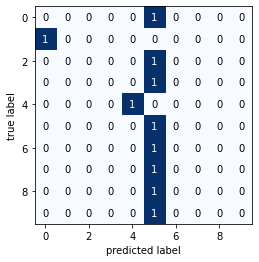

In [43]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [44]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.12      1.00      0.22         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.20        10
   macro avg       0.11      0.20      0.12        10
weighted avg       0.11      0.20      0.12        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Dataset4-Hard

##Import Dataset

In [45]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv")
df.columns=["questions","answers","AnswerCode"]

df

,questions,answers,AnswerCode
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [46]:
import pandas as pd

#Load dataset and examine dataset, rename columns to questions and answers

df_test=pd.read_excel("FAQ_test_Hard.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,Please provide how data science jobs are in th...,2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How has the Covid impacted job?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,Tell me about the skills required for Data sci...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Is advanced knowledge of ML required?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,What are the tasks performed by a data scienti...,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,How much is data structure important for data ...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,How much maths knowledge is required to get a ...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview is done for data ...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How much coding experience is required for dat...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##Data Preprocessing

In [47]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#cleaning test data questions
def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(tf,stopwords=False):    
    sents=tf[["questions"]]
    cleaned_sentences=[]

    for index,row in tf.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords)
        cleaned_sentences.append(cleaned)
    return cleaned_sentences

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences)

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords)

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

In [48]:
print(cleaned_sentences_with_stopwords[0])

what does the job hunting experience look like 


##Glove Model

In [49]:
from gensim.models import Word2Vec 
import gensim.downloader as api

glove_model=None
try:
    glove_model = gensim.models.KeyedVectors.load("glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")

glove_embedding_size=len(glove_model['computer'])

Loaded glove model


In [50]:
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test)

['how difficult is it to find a job', 'please provide how data science jobs are in the market', 'how has the covid impacted job', 'tell me about the skills required for data science in the industry', 'is advanced knowledge of ml required', 'what are the tasks performed by a data scientist in a day', 'how much is data structure important for data science positions', 'how much maths knowledge is required to get a data science job', 'how many rounds of interview is done for data science roles', 'how much coding experience is required for data science positions']


In [51]:
def getWordVec(word,model):
        samp=model['computer']
        vec=[0]*len(samp);
        try:
                vec=model[word]
        except:
                vec=[0]*len(samp)
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel)
        vec=numpy.array([0]*len(samp))
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1
            vec=vec+numpy.array(getWordVec(word,embeddingmodel))

        return vec.reshape(1, -1)

In [52]:
#With glove for original question dataset
import numpy
sent_embeddings=[]
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,glove_model))

In [53]:
#With glove for test question dataset
import numpy
sent_embeddings_test=[]
for sent_test in cleaned_sentences_test:
    sent_embeddings_test.append(getPhraseEmbedding(sent_test,glove_model))

In [54]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1
    index_sim=-1
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0]
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim
        index_sim=index

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])        
  df_test=FAQdf_test 
retrieveAndPrintFAQAnswer(sent_embeddings_test,sent_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test)



Question:  how difficult is it to find a job


Retrieved:  How does a typical day of a data scientist look like?
Answer: Here are some tasks in the typical day of a data scientist:

Make a plan for the day
Look at data, what clean up is required, figure out what models can be built
Talk to various stakeholders about what modeling is possible and help them narrow down to something useful for the business
Build models, test and debug (takes a long time)
Parameter tuning – test tons and tons of parameters (takes a long time)
Come up with prod architecture to get deployment ready
Write ML pipeline for production ready modeles – deploy them
Wait for long time till we have a significant sample to see if they are working
Analyze and see whether the models are working as expected, have any impact
Come up with improvements/ corrections based on prod feedback and prepare for next iteration.
Meeting with team members / daily sprints / bug triages based on production feedback – Interaction with 

In [55]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,6.0,NaN,What does the job hunting experience look like ?,How does a typical day of a data scientist loo...
1,Please provide how data science jobs are in th...,2,6.0,NaN,Any insights you can offer about the DS job ma...,How does a typical day of a data scientist loo...
2,How has the Covid impacted job?,3,6.0,NaN,What's the impact of Covid on hiring for DS ro...,How does a typical day of a data scientist loo...
3,Tell me about the skills required for Data sci...,4,6.0,NaN,What skills and qualities do employers look fo...,How does a typical day of a data scientist loo...
4,Is advanced knowledge of ML required?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What are the tasks performed by a data scienti...,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,How much is data structure important for data ...,7,6.0,NaN,Is preparation of algorithms and data structur...,How does a typical day of a data scientist loo...
7,How much maths knowledge is required to get a ...,8,6.0,NaN,What is the mathematical background required t...,How does a typical day of a data scientist loo...
8,How many rounds of interview is done for data ...,9,6.0,NaN,What are the various rounds in a data scientis...,How does a typical day of a data scientist loo...
9,How much coding experience is required for dat...,10,6.0,NaN,What level of proficiency is needed for a data...,How does a typical day of a data scientist loo...


In [56]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,6.0,InCorrect,What does the job hunting experience look like ?,How does a typical day of a data scientist loo...
1,Please provide how data science jobs are in th...,2,6.0,InCorrect,Any insights you can offer about the DS job ma...,How does a typical day of a data scientist loo...
2,How has the Covid impacted job?,3,6.0,InCorrect,What's the impact of Covid on hiring for DS ro...,How does a typical day of a data scientist loo...
3,Tell me about the skills required for Data sci...,4,6.0,InCorrect,What skills and qualities do employers look fo...,How does a typical day of a data scientist loo...
4,Is advanced knowledge of ML required?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What are the tasks performed by a data scienti...,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,How much is data structure important for data ...,7,6.0,InCorrect,Is preparation of algorithms and data structur...,How does a typical day of a data scientist loo...
7,How much maths knowledge is required to get a ...,8,6.0,InCorrect,What is the mathematical background required t...,How does a typical day of a data scientist loo...
8,How many rounds of interview is done for data ...,9,6.0,InCorrect,What are the various rounds in a data scientis...,How does a typical day of a data scientist loo...
9,How much coding experience is required for dat...,10,6.0,InCorrect,What level of proficiency is needed for a data...,How does a typical day of a data scientist loo...


In [57]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [58]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]],

       [[1, 8],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]]])

In [59]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

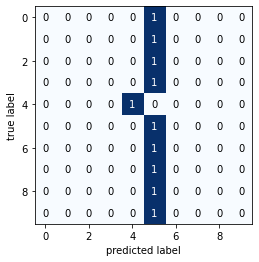

In [60]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [61]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.11      1.00      0.20         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.20        10
   macro avg       0.11      0.20      0.12        10
weighted avg       0.11      0.20      0.12        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
